In [1]:
from src.models.diffusion_module import LightningDiffusionModule, DiffusionModel
from src.models.TwoResUnet import TwoResUNet
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

model= TwoResUNet(dim = 64)
diff_model = DiffusionModel(model = model)
light_module = LightningDiffusionModule(model=diff_model,  wandb_flag = False)
checkpoint = torch.load("results/classic/diffusion_model-epoch=139-train_loss=0.00.ckpt")
print(checkpoint)
light_module.on_load_checkpoint(checkpoint=checkpoint)
light_module = light_module
print(light_module.diff_model)
light_module.diff_model.eval()

image = light_module.diff_model.p_sample_loop((1,3,64,64))

plt.imshow(image)
plt.axis('off')  # Hide axes for better display
plt.show()


ModuleNotFoundError: No module named 'src.models.models'

In [2]:
onnx_path = "results/onnx/diffusion_model.onnx"

torch.onnx.export(
    light_module.diff_model.diffusion_model,       # The model being converted
    (dummy_input,dummy_t),                   # Example input to trace the model
    onnx_path,                     # Path to save the ONNX file
    export_params=True,            # Store the trained parameters in the model file
    opset_version=11,              # ONNX version to export the model to
    do_constant_folding=True,      # Whether to execute constant folding for optimization
    input_names=['input', 'time'],         # Model input names
    output_names=['output'],       # Model output names
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}, 'time': {0: 'batch_size'}}  # Variable length axes
)

print(f"Model exported to {onnx_path}")

Model exported to results/onnx/diffusion_model.onnx


In [9]:
from onnxruntime.quantization import quantize_dynamic, QuantType

quantized_model_path = "results/onnx/diffusion_model_quantized.onnx"

quantize_dynamic(
    model_input=onnx_path,                # Input ONNX model path
    model_output=quantized_model_path,    # Output quantized model path
    op_types_to_quantize=['Matmul'],  # Operations to quantize (you can customize this list)
    per_channel=True,                     # Enable per-channel quantization
    reduce_range=True,                    # Reduce the range of quantized values
    weight_type=QuantType.QInt8           # Quantization type (can also be QuantType.QUInt8)
)

print(f"Quantized model saved to {quantized_model_path}")


Quantized model saved to results/onnx/diffusion_model_quantized.onnx


In [10]:
import onnxruntime as ort

# Load the quantized model
ort_session = ort.InferenceSession(quantized_model_path)

# # Run inference
# outputs = ort_session.run(None, {"input": dummy_input.cpu().numpy()})

# for input in ort_session.get_inputs():
#     print(f"Input Name: {input.name}, Shape: {input.shape}")
# print(outputs)

In [4]:
def extract(arr, t, shape):
    batch_size = shape[0]
    out = np.take(arr, t)
    out = np.reshape(out, (1,) * (len(shape) - 1))  # Reshape to match the number of dimensions except batch size
    return np.broadcast_to(out, shape)


def p_sample(ort_session, x, t, betas, sqrt_recip_alphas, sqrt_one_minus_alphas_cumprod, posterior_variance):
    t = np.array([t], dtype=np.int64)
    preds = ort_session.run(None, {"input": x.cpu().numpy(), "time": t})[0]
    betas_t = extract(betas, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)

    predicted_mean = sqrt_recip_alphas_t * (x.cpu().numpy() - betas_t * preds / sqrt_one_minus_alphas_cumprod_t)

    if t == 0:
        return predicted_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = np.random.randn(*x.shape).astype(np.float32)
        return predicted_mean + np.sqrt(posterior_variance_t) * noise


def p_sample_loop(ort_session, shape, betas, sqrt_recip_alphas, sqrt_one_minus_alphas_cumprod, posterior_variance, num_timesteps):
    
    img = np.random.randn(*shape).astype(np.float32)

    for t in tqdm(reversed(range(num_timesteps)), total=num_timesteps):
        img = p_sample(ort_session, torch.tensor(img), t, betas, sqrt_recip_alphas, sqrt_one_minus_alphas_cumprod, posterior_variance)
    
    return torch.tensor(img).to('cuda')

100%|██████████| 1000/1000 [00:25<00:00, 39.13it/s]


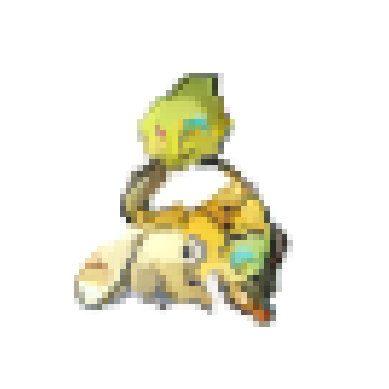

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# These values would be obtained from your model's initialization, converted to numpy arrays
betas = np.array(light_module.diff_model.betas.cpu().numpy())
sqrt_recip_alphas = np.array(light_module.diff_model.sqrt_recip_alphas.cpu().numpy())
sqrt_one_minus_alphas_cumprod = np.array(light_module.diff_model.sqrt_one_minus_alphas_cumprod.cpu().numpy())
posterior_variance = np.array(light_module.diff_model.posterior_variance.cpu().numpy())

num_timesteps = light_module.diff_model.num_timesteps
img_shape = (1, 3, light_module.diff_model.image_size, light_module.diff_model.image_size)

generated_images = p_sample_loop(ort_session, img_shape, betas, sqrt_recip_alphas, sqrt_one_minus_alphas_cumprod, posterior_variance, num_timesteps)

# Save or display the generated image

# Assuming `generated_images` is the output from the p_sample_loop
# If necessary, move the tensor to CPU and convert it to numpy
image = generated_images.squeeze().detach().cpu().numpy()

# If the image is in [-1, 1], unnormalize it to [0, 1]
image = (image + 1) / 2

# Transpose the image to (H, W, C) if necessary (from (C, H, W))
image = np.transpose(image, (1, 2, 0))

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes for better display
plt.show()


In [48]:
import numpy as np
import json

# Assuming betas, sqrt_recip_alphas, sqrt_one_minus_alphas_cumprod, and posterior_variance are numpy arrays

data = {
    "betas": betas.tolist(),
    "sqrt_recip_alphas": sqrt_recip_alphas.tolist(),
    "sqrt_one_minus_alphas_cumprod": sqrt_one_minus_alphas_cumprod.tolist(),
    "posterior_variance": posterior_variance.tolist()
}

# Save as a JSON file
with open('web-app/diffusion_buffers.json', 'w') as json_file:
    json.dump(data, json_file)
